In [8]:
using NBInclude
@nbinclude("functions.ipynb")

All function imported


In [16]:
# Load the model and test set loader incoherent
epoch_to_load_inco = 25
dir_inco = "../trained_GNN/MNIST_identity_v4"
encoder_μ_inco, encoder_logvar_inco, W1_inco, W2_inco, W3_inco, Q_inco = load_model_sep(dir_inco, epoch_to_load_inco);

# Load the model and test set loader unenforced
epoch_to_load_co = 25
dir_co = "../trained_GNN/MNIST_v2"
encoder_μ_co, encoder_logvar_co, W1_co, W2_co, W3_co, Q_co = load_model_sep(dir_co, epoch_to_load_co);

# Load the model and test set loader unenforced
epoch_to_load_co = 20
dir_co = "../trained_GNN/MNIST"
encoder_μ_co_sig, encoder_logvar_co_sig, decoder = load_model(dir_co, epoch_to_load_co);


#setup
x_dim = 784
k = 20
tolerance = 1e-7; max_iter = 5000; out_toggle = 0
opt = Flux.Optimise.ADAM(.1);

G_inco(z) =Q_inco *W3_inco*relu(W2_inco*relu(W1_inco*z))
G_co(z) = Q_co*relu(W2_co*relu(W1_co*z))
G_co_sig(z) = sigmoid(Flux.params(decoder)[3] * 
                relu(Flux.params(decoder)[2] * 
                relu(Flux.params(decoder)[1]*z))
                );


Loading model...Done
Loading model...Done
Loading model...Done

In [ ]:
k = 20
m_list = [10, 15, 20, 25, 30, 35, 40, 45, 50, 100, 150, 200, 250];
batch_size = 64
shuffle_data = true


nums = 1:9
z_co_list = zeros(length(nums), k)
z_co_sig_list = zeros(length(nums), k)
z_inco_list = zeros(length(nums), k)

x_true_list = zeros(length(nums), 784)
z_est_inco_matrix = zeros(length(nums), k, length(m_list))
z_est_co_matrix = zeros(length(nums), k, length(m_list))
z_est_co_sig_matrix = zeros(length(nums), k, length(m_list))

Threads.@threads for num_index in 1:length(nums)
    num = nums[num_index]
    dataloader = get_test_loader(batch_size, shuffle_data)
    (x_batch, y_batch) = first(dataloader)
    i = 1
    while y_batch[i] != num
    i += 1
    end
    x_true= x_batch[:, i];

    z_est_inco_list = zeros(k, length(m_list))
    z_est_co_list = zeros(k, length(m_list))
    z_est_co_sig_list = zeros(k, length(m_list))

    x_true_list[num_index,:] = x_true

    # Apply reparameterisation trick to sample latent
    μ = encoder_μ_inco(x_true)
    logvar_inco = encoder_logvar_inco(x_true)
    z_inco = μ + randn(Float32, size(logvar_inco)) .* exp.(0.5f0 * logvar_inco)
    z_inco_list[num_index,:] = z_inco

    μ = encoder_μ_co(x_true)
    logvar_co = encoder_logvar_co(x_true)
    # Apply reparameterisation trick to sample latent
    z_co = μ + randn(Float32, size(logvar_co)) .* exp.(0.5f0 * logvar_co)
    z_co_list[num_index,:] = z_co

    μ = encoder_μ_co_sig(x_true)
    logvar_co_sig = encoder_logvar_co_sig(x_true)
    # Apply reparameterisation trick to sample latent
    z_co_sig = μ + randn(Float32, size(logvar_co_sig)) .* exp.(0.5f0 * logvar_co_sig)
    z_co_sig_list[num_index,:] = z_co_sig

     for i in 1:length(m_list)
        m = m_list[i]
        F_sub = sample_fourier(m, x_dim)  # subsampling DCT for measurement matrix
        F_sub = F_sub * sqrt(x_dim)/sqrt(m); #normalization  

        y = F_sub * G_inco(z_inco) # measurement vector using subsampled DCT matrix
        z_est_inco = randn(k) #initialization for algorithm
        z_est_inco = estimated_code(opt, G_inco, y, F_sub, z_est_inco; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
        z_est_inco_list[:,i] = z_est_inco

        y = F_sub * G_co(z_co) # measurement vector using subsampled DCT matrix
        z_est_co = randn(k) #initialization for algorithm
        z_est_co = estimated_code(opt, G_co, y, F_sub, z_est_co; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
        z_est_co_list[:,i] = z_est_co

        y = F_sub * G_co_sig(z_co_sig) # measurement vector using subsampled DCT matrix
        z_est_co_sig = randn(k) #initialization for algorithm
        z_est_co_sig = estimated_code(opt, G_co_sig, y, F_sub, z_est_co_sig; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
        z_est_co_sig_list[:,i] = z_est_co_sig
    end

    z_est_inco_matrix[num_index,:,:] = z_est_inco_list
    z_est_co_matrix[num_index,:,:] = z_est_co_list
    z_est_co_sig_matrix[num_index,:,:] = z_est_co_sig_list

end



In [68]:
# save("../saved_data/MNIST_image_recovery_20_sigmoid.jld", "z_inco_list", z_inco_list, "z_co_list", z_co_list, "z_co_sig_list", z_co_sig_list,"x_true_list", x_true_list, "z_est_inco_matrix", z_est_inco_matrix, "z_est_co_matrix", z_est_co_matrix, "z_est_co_sig_matrix", z_est_co_sig_matrix, "m_list", m_list)

In [ ]:
k = 20
m_list = [10, 15, 20, 25, 30, 35, 40, 45, 50, 100, 150, 200, 250, 300, 400, 500, 600];
batch_size = 6400
shuffle_data = true

trials = 10
recon_error_matrix_inco = zeros(length(m_list), trials)
recon_error_matrix_co = zeros(length(m_list), trials)
recon_error_matrix_co_sig = zeros(length(m_list), trials)


Threads.@threads for trials in 1:trials
    recon_error_list_inco = []
    recon_error_list_co = []
    recon_error_list_co_sig = []

    for m in m_list
        num = rand(1:9)
        dataloader = get_test_loader(batch_size, shuffle_data)
        (x_batch, y_batch) = first(dataloader)
        i = 1
        while y_batch[i] != num
            i += 1
        end
        x_true= x_batch[:, i];
    
        # Apply reparameterisation trick to sample latent
        μ = encoder_μ_inco(x_true)
        logvar_inco = encoder_logvar_inco(x_true)
        z_inco = μ + randn(Float32, size(logvar_inco)) .* exp.(0.5f0 * logvar_inco)
    
        # Apply reparameterisation trick to sample latent
        μ = encoder_μ_co(x_true)
        logvar_co = encoder_logvar_co(x_true)
        z_co = μ + randn(Float32, size(logvar_co)) .* exp.(0.5f0 * logvar_co)

        μ = encoder_μ_co_sig(x_true)
        logvar_co = encoder_logvar_co_sig(x_true)
        # Apply reparameterisation trick to sample latent
        z_co_sig = μ + randn(Float32, size(logvar_co)) .* exp.(0.5f0 * logvar_co)


        F_sub = sample_fourier(m, x_dim)  # subsampling DCT for measurement matrix
        F_sub = F_sub * sqrt(x_dim)/sqrt(m); #normalization  

        y = F_sub * G_inco(z_inco) # measurement vector using subsampled DCT matrix
        z_est_inco = randn(k) #initialization for algorithm
        z_est_inco = estimated_code(opt, G_inco, y, F_sub, z_est_inco; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
        push!(recon_error_list_inco, relative_error(G_inco(z_inco), G_inco(z_est_inco)))

        y = F_sub * G_co(z_co) # measurement vector using subsampled DCT matrix
        z_est_co = randn(k) #initialization for algorithm
        z_est_co = estimated_code(opt, G_co, y, F_sub, z_est_co; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
        push!(recon_error_list_co, relative_error(G_co(z_co), G_co(z_est_co)))

        y = F_sub * G_co_sig(z_co_sig) # measurement vector using subsampled DCT matrix
        z_est_co_sig = randn(k) #initialization for algorithm
        z_est_co_sig = estimated_code(opt, G_co_sig, y, F_sub, z_est_co_sig; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
        push!(recon_error_list_co_sig, relative_error(G_co_sig(z_co_sig), G_co_sig(z_est_co_sig)))

    end
    recon_error_matrix_inco[:, trials] = recon_error_list_inco
    recon_error_matrix_co[:, trials] = recon_error_list_co
    recon_error_matrix_co_sig[:, trials] = recon_error_list_co_sig

end





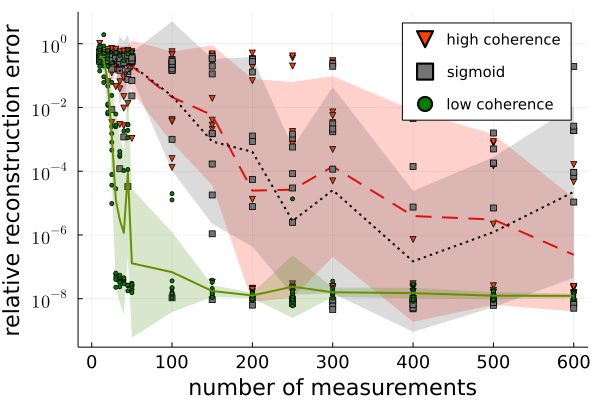

In [12]:

log_recon_error_matrix_co = log10.(recon_error_matrix_co[:, :])
average_recon_co = mean(log_recon_error_matrix_co, dims=2)
std_recon_co = std(log_recon_error_matrix_co, dims=2)
plot(m_list, average_recon_co + std_recon_co, fillrange = average_recon_co - std_recon_co, fillalpha = .2, c = cs[40], label = false, linecolor = invisible())
scatter!(kron(m_list,ones(1,trials))[:], log_recon_error_matrix_co[:], label =:false, c = cs[100], markershape = :dtriangle, lab="high coherence", legendfontsize=10, markersize = 3)
plot!(m_list, average_recon_co, linewidth = 2, color = cs[10], label =false, linestyle =:dash )
yticks = [-8:2:0;]
yticks!(yticks, [L"10^{%$y}" for y in yticks])

scatter!([1],[0], label=" ", ms=0, mc=:white, msc=:white)

log_recon_error_matrix_co_sig = log10.(recon_error_matrix_co_sig[:, :])
average_recon_co_sig = mean(log_recon_error_matrix_co_sig, dims=2)
std_recon_co_sig = std(log_recon_error_matrix_co_sig, dims=2)
plot!(m_list, average_recon_co_sig + std_recon_co_sig, fillrange = average_recon_co_sig - std_recon_co_sig, fillalpha = .2, c = cs2[40], label = false, linecolor = invisible())
scatter!(kron(m_list,ones(1,trials))[:], log_recon_error_matrix_co_sig[:], label =:false, c = cs2[10], markershape = :square, lab="sigmoid", legendfontsize=10, fillalpha = .2, markersize = 3)
plot!(m_list, average_recon_co_sig, linewidth = 2, color = cs2[100], label =false, linestyle =:dot )
yticks = [-8:2:0;]
yticks!(yticks, [L"10^{%$y}" for y in yticks])

scatter!([1],[0], label=" ", ms=0, mc=:white, msc=:white)


log_recon_error_matrix_inco = log10.(recon_error_matrix_inco[:, :])
average_recon_inco = mean(log_recon_error_matrix_inco, dims=2)
std_recon_inco = std(log_recon_error_matrix_inco, dims=2)
plot!(m_list, average_recon_inco + std_recon_inco, fillrange = average_recon_inco - std_recon_inco, fillalpha = .2, c = cs[440], label = false, linecolor = invisible())
scatter!(kron(m_list,ones(1,trials))[:], log_recon_error_matrix_inco[:], label =:false, c = cs[500], lab="low coherence", markersize = 3)
plot!(m_list, average_recon_inco, xlabel = "number of measurements", ylabel = "relative reconstruction error", linewidth = 2, color = cs[400], label =false,  xlabelfontsize = 15, ylabelfontsize = 15, xtickfontsize = 12, ytickfontsize = 12 )

# savefig("figures/all_measurements_v3.pdf")